# Libraries and Preparation


In [ ]:
!pip install rasterio

In [2]:
import os
import shutil
import pandas as pd
from tqdm import tqdm
import tarfile
import random
from joblib import Parallel, delayed
from PIL import Image
import numpy as np
from time import time
from pathlib import Path
from google.colab import drive
import rasterio
from matplotlib import pyplot as plt
import seaborn as sns
from rasterio.plot import show
import xarray as xr
from pathlib import Path

Run the !wget to download the Crop harvest dataset, this contains about 25g, so part of the proces will be to extract 1g of random images

In [ ]:

!wget https://zenodo.org/record/10251170/files/eo_data.tar.gz?download=1 -O eo_data.tar.gz

This line of the code creates a file called crop_harvest which opens the .tar to unzip file and extract the tif images, the code pics the ammount of .tif images randomly until it reaches 1gb

In [ ]:


# Ruta de salida
output_dir = Path("CropHarvest_extract")
output_dir.mkdir(parents=True, exist_ok=True)

# Límite de extracción: 1 GB
size_limit = 1 * 1024**3  # 1 GB en bytes
total_bytes = 0
count = 0

# Abrir el archivo .tar.gz y extraer archivos .tif secuencialmente
with tarfile.open("eo_data.tar.gz", "r:gz") as tar:
    for member in tar:
        if not member.isfile() or not member.name.endswith(".tif"):
            continue

        if total_bytes + member.size > size_limit:
            break

        tar.extract(member, path=output_dir)
        total_bytes += member.size
        count += 1

print(f"{count} Extraction done. Total: {total_bytes / (1024 ** 2):.2f} MB")


✅ 3070 archivos extraídos. Total: 1023.67 MB


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data preprocessing with joblib and Paralelism using Crobharvest DS




In this part, Data analysis will be processed with CropHarvest with the intention to measure the parallel processing time.


Creating a list with .tif images

In [5]:
file_path = "/content/drive/MyDrive/CropHarvest_extract/eo_data"
routes = [os.path.join(file_path, f) for f in os.listdir(file_path) if f.endswith(".tif")]


## Statistics

Rasterio is used in a GeoTiff .tiff images.

This code takes the file path and reads the RGB colors of the images to take statistics as the GEOTIFF images also contain spatial data.

In [6]:
def img_preprocessing(path: str) -> dict:
    filename = Path(path).name

    try:
        with rasterio.open(path) as src:
            arr = src.read(1).astype(float)

        return {
            "file": filename,
            "mean": np.nanmean(arr),
            "std":  np.nanstd(arr),
            "min":  np.nanmin(arr),
            "max":  np.nanmax(arr),
            "shape": arr.shape
        }

    except Exception as e:
        return {
            "file": filename,
            "mean": None,
            "std":  None,
            "min":  None,
            "max":  None,
            "shape": None,
            "error": str(e)
        }


## Parallel execution

This parallel job would be applied in n_job in n nucleus, in this case -1 indicades that the process will run in all available routes in the moment the code is executed.

Then, it'll include all the results in a DF including errors, this to check if there's any part of the preprocessing made above that the libraries could not process due to the kind of images we are using.

This code uses Joblib’s Parallel and delayed to apply the function img_preprocessing to each path in the list routes in parallel. The delayed wrapper ensures that each function call is queued for parallel execution instead of being executed immediately. Parallel(n_jobs=-1) runs as many tasks in parallel as there are CPU cores available. This approach speeds up the processing of large numbers of independent tasks like image analysis. The final result, statistics, is a list of outputs in the same order as the input paths.

In [ ]:
start_time = time()

statistics = Parallel(n_jobs=-1)(
    delayed(img_preprocessing)(path) for path in routes
)

elapsed = time() - start_time
print(f"Parallel preprocessing in  {elapsed:.2f} s.")

# Results to DF
df_statistics = pd.DataFrame(statistics)
df_statistics.head()


## Mean values consistently negative

Most images have average values between –15 and –5, indicating that the pixel values themselves are negative due to how the satellite bands are scaled.

**Central concentration around –10**

There's a noticeable peak around –10, suggesting that most images have similar negative mean values after preprocessing.

**Longer left tail below –20**

Some images have means as low as –25 or –30, indicating darker or sparser reflectance in those particular bands or scenes.

## Why mean values are negative:
According to GIS experts, it's common in certain surface reflectance products (e.g. Landsat) to have negative pixel values for non-vegetated surfaces—like water, clouds, rocks, or masked areas—because they reflect more in red than near-infrared. These values don't indicate errors; rather, they reflect how the data were retrieved or preprocessed.

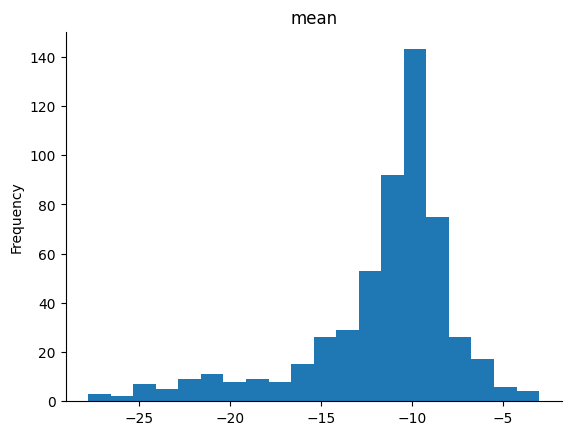



##Parallel execution comparission between multiple cores

n_jobs=1: 174.33 s
n_jobs=2: 108.31 s
n_jobs=4: 108.15 s
n_jobs=8: 123.36 s
n_jobs=-1: 117.29 s


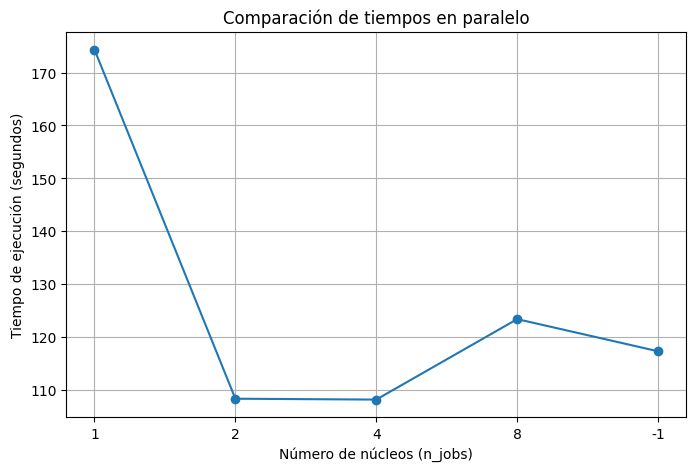

In [7]:

n_jobs_list = [1, 2, 4, 8, -1]
execution_times = []

for n in n_jobs_list:
    start_time = time()

    statistics_test = Parallel(n_jobs=n)(
        delayed(img_preprocessing)(path) for path in routes
    )

    elapsed = time() - start_time
    execution_times.append(elapsed)
    print(f"n_jobs={n}: {elapsed:.2f} s")

# Graficar resultados
plt.figure(figsize=(8, 5))
plt.plot([str(n) for n in n_jobs_list], execution_times, marker='o')
plt.xlabel("Número de núcleos (n_jobs)")
plt.ylabel("Tiempo de ejecución (segundos)")
plt.title("Comparación de tiempos en paralelo")
plt.grid(True)
plt.show()


## To get more information of the image, we want to explore the dimension prior to apply a NDVI

In this case we´ll use one as an example to visualize.

In [ ]:


# filepath
ruta = '/content/drive/MyDrive/CropHarvest_extract/eo_data/1000-togo_2019-02-06_2020-02-01.tif'

# Open .tiff file
with rasterio.open(ruta) as src:
    print(f"Dimensiones: {src.width} x {src.height}")
    print(f"Cantidad de bandas: {src.count}")
    print(f"CRS (sistema de referencia): {src.crs}")
    print(f"Tipo de datos: {src.dtypes}")
    print(f"Shape esperado: ({src.count}, {src.height}, {src.width})")

    # name the ranges
    for i in range(1, src.count + 1):
        band = src.read(i)
        print(f"Banda {i} - Min: {band.min()}, Max: {band.max()}, Media: {band.mean()}")

    # show the visualization
    show(src.read(1), title="Banda 1")


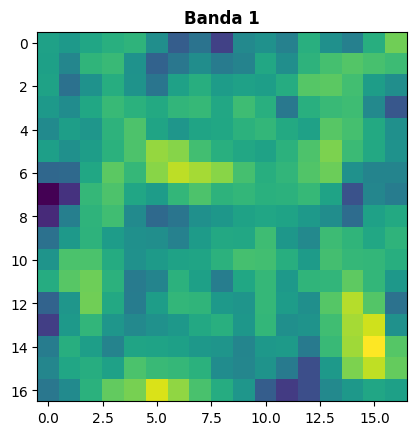

## NDVI estimation

NDVI (Normalized Difference Vegetation Index)

Is a remotely‑sensed indicator used to assess the density and health of green vegetation. It compares the reflectance of near‑infrared (NIR) light—strongly reflected by healthy plants—with red light, which is strongly absorbed by chlorophyll, via the formula:

*NDVI = (NIR – Red) / (NIR + Red)*

**The index ranges from –1 to +1:**

Low (near 0 or negative): water, bare soil, or built-up areas

High (0.6–0.9): dense, healthy vegetation

**NDVI is widely utilized in agriculture, forestry, land monitoring, and climate studies to track plant vitality, detect drought, and optimize resource use.**

In [9]:
def ndvi_est(path: str, red_band=30, nir_band=90) -> dict:
    file = Path(path).name

    try:
        with rasterio.open(path) as src:
            red = src.read(red_band).astype(float)
            nir = src.read(nir_band).astype(float)
            ndvi = (nir - red) / (nir + red + 1e-5)

        return {
            "file": file,
            "ndvi_mean": np.nanmean(ndvi),
            "ndvi_std":  np.nanstd(ndvi)
        }

    except Exception as e:
        return {
            "file": file,
            "ndvi_mean": None,
            "ndvi_std":  None,
            "error":     str(e)
        }

## Parallel execution with Joblib

In [ ]:
start_time = time()

ndvi = Parallel(n_jobs=-1)(
    delayed(ndvi_est)(path) for path in routes
)

elapsed = time() - start_time
print(f"Parallel preprocessing in  {elapsed:.2f} s.")

# Results to DF
df_ndvi = pd.DataFrame(ndvi)
df_ndvi.head()


Parallel preprocessing in  110.15 s.


,file,ndvi_mean,ndvi_std,error
0,234-ethiopia_2020-02-07_2021-02-01.tif,0.287938,0.063878,NaN
1,245-ethiopia_2020-02-07_2021-02-01.tif,0.282448,0.051512,NaN
2,538-ethiopia_2020-02-07_2021-02-01.tif,0.252555,0.095602,NaN
3,698-ethiopia_2020-02-07_2021-02-01.tif,0.220722,0.072024,NaN
4,246-togo_2019-02-06_2020-02-01.tif,0.332164,0.084085,NaN


## Histogram of NDVI Mean Values

This histogram shows the distribution of average NDVI values across all processed GeoTIFF images.

Most images have NDVI between 0.1 and 0.4, indicating moderate vegetation cover, likely consistent with agricultural or savannah landscapes.

The peak near 0.25 suggests healthy but not dense vegetation is common across the dataset.

A small number of images show negative NDVI values, which may correspond to bare soil, urban areas, water bodies, or invalid calculations (e.g. clouds or missing data).

Outliers with NDVI < -1 may signal data quality issues or require masking.


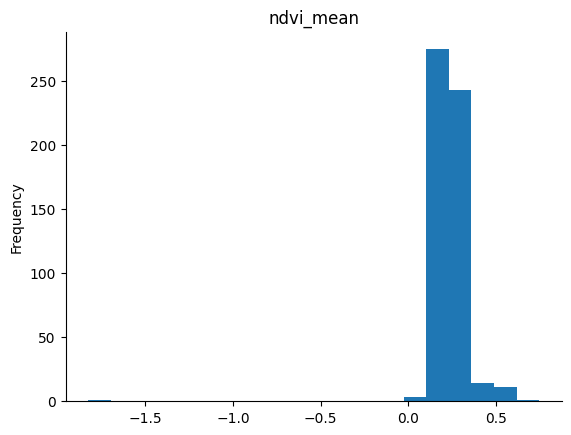

##Parallel execution comparission between multiple cores

NDVI con n_jobs=1: 175.44 s
NDVI con n_jobs=2: 111.15 s
NDVI con n_jobs=4: 109.44 s
NDVI con n_jobs=8: 111.93 s
NDVI con n_jobs=-1: 110.95 s


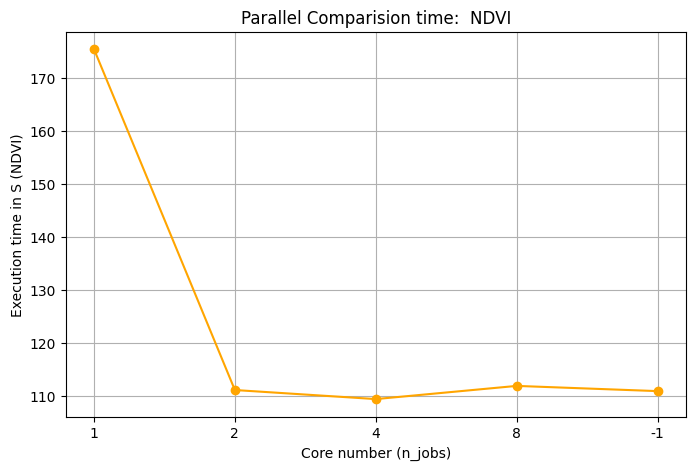

In [10]:
n_jobs_list = [1, 2, 4, 8, -1]
execution_times_ndvi = []

for n in n_jobs_list:
    start_time = time()

    ndvi_test = Parallel(n_jobs=n)(
        delayed(ndvi_est)(path) for path in routes
    )

    elapsed = time() - start_time
    execution_times_ndvi.append(elapsed)
    print(f"NDVI con n_jobs={n}: {elapsed:.2f} s")

# Plot the results
plt.figure(figsize=(8, 5))
plt.plot([str(n) for n in n_jobs_list], execution_times_ndvi, marker='o', color='orange')
plt.xlabel("Core number (n_jobs)")
plt.ylabel("Execution time in S (NDVI)")
plt.title("Parallel Comparision time:  NDVI")
plt.grid(True)
plt.show()


# Data preprocessing without Paralelism (SOPHIA)

In [11]:
start_time = time()

statistics_seq = []
for path in routes:
    statistics_seq.append(img_preprocessing(path))

elapsed_seq = time() - start_time
print(f"Secuential preprocessing in {elapsed_seq:.2f} s.")

# Convertir a DataFrame
df_statistics_seq = pd.DataFrame(statistics_seq)
df_statistics_seq.head()

Secuential preprocessing in 166.54 s.


,file,mean,std,min,max,shape,error
0,234-ethiopia_2020-02-07_2021-02-01.tif,-15.134761,1.798779,-21.686744,-10.121315,"(17, 17)",NaN
1,245-ethiopia_2020-02-07_2021-02-01.tif,-15.291374,1.384763,-20.250263,-11.684926,"(18, 17)",NaN
2,538-ethiopia_2020-02-07_2021-02-01.tif,-9.775265,1.785382,-16.077098,-6.173658,"(18, 17)",NaN
3,698-ethiopia_2020-02-07_2021-02-01.tif,-12.070617,2.255461,-20.197721,-7.952914,"(18, 17)",NaN
4,246-togo_2019-02-06_2020-02-01.tif,-12.455573,2.140130,-17.560089,-6.417751,"(17, 18)",NaN


In [12]:
start_time = time()

ndvi_seq = []
for path in routes:
    ndvi_seq.append(ndvi_est(path))

elapsed_seq = time() - start_time
print(f"Secuential NDVI computation in {elapsed_seq:.2f} s.")

# Convertir a DataFrame
df_ndvi_seq = pd.DataFrame(ndvi_seq)
df_ndvi_seq.head()

Secuential NDVI computation in 165.56 s.


,file,ndvi_mean,ndvi_std,error
0,234-ethiopia_2020-02-07_2021-02-01.tif,0.980654,0.007068,NaN
1,245-ethiopia_2020-02-07_2021-02-01.tif,0.883811,0.128490,NaN
2,538-ethiopia_2020-02-07_2021-02-01.tif,0.906364,0.031626,NaN
3,698-ethiopia_2020-02-07_2021-02-01.tif,0.947280,0.015482,NaN
4,246-togo_2019-02-06_2020-02-01.tif,0.973695,0.041084,NaN


In [13]:
# Comparación de tiempos
print(f"Tiempo paralelo (estadísticas): {elapsed:.2f} s")
print(f"Tiempo secuencial (estadísticas): {elapsed_seq:.2f} s")

# Comparar DataFrames
comparison = df_statistics.merge(df_statistics_seq, on='file', suffixes=('_par', '_seq'))
comparison[['file', 'mean_par', 'mean_seq', 'std_par', 'std_seq']].head()

Tiempo paralelo (estadísticas): 110.95 s
Tiempo secuencial (estadísticas): 165.56 s


NameError: name 'df_statistics' is not defined

In [ ]:
# Tiempos para comparación
times = {
    'Paralelo': elapsed,
    'Secuencial': elapsed_seq
}

plt.figure(figsize=(6, 4))
sns.barplot(x=list(times.keys()), y=list(times.values()), palette='Blues_d')
plt.title('Tiempo de Ejecución - Estadísticas')
plt.ylabel('Tiempo (segundos)')
plt.xlabel('Método')
plt.show()

In [ ]:
# Comparación gráfica de la media
plt.figure(figsize=(10, 6))
sns.scatterplot(data=comparison, x='mean_par', y='mean_seq')
plt.plot([comparison['mean_par'].min(), comparison['mean_par'].max()],
         [comparison['mean_par'].min(), comparison['mean_par'].max()],
         color='red', linestyle='--', label='Línea de identidad')
plt.title('Comparación de medias: Paralelo vs Secuencial')
plt.xlabel('Media (Paralelo)')
plt.ylabel('Media (Secuencial)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
ndvi_times = {
    'Paralelo NDVI': elapsed,
    'Secuencial NDVI': elapsed_seq
}

plt.figure(figsize=(6, 4))
sns.barplot(x=list(ndvi_times.keys()), y=list(ndvi_times.values()), palette='Greens_d')
plt.title('Tiempo de Ejecución - Cálculo NDVI')
plt.ylabel('Tiempo (segundos)')
plt.xlabel('Método')
plt.show()